In [23]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

from pylgmath import Transformation
from pysteam.trajectory import Time
from pysteam.trajectory.const_vel import Interface as TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver, DoglegGaussNewtonSolver
from pysteam.evaluable import vspace as vspaceev, se3 as se3ev
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar

import scipy.interpolate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_smoothing_spline

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [129]:
#import training dataset

dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/slip_dataset_all.pkl')
dataset_snow = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_b/slip_dataset_all.pkl')

print(dataset.head())

   init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0         0.0         0.0         0.0            0.0             0.0   
1         0.0         0.0         0.0            0.0             0.0   
2         0.0         0.0         0.0            0.0             0.0   
3         0.0         0.0         0.0            0.0             0.0   
4         0.0         0.0         0.0            0.0             0.0   

   init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0           0.0         0.0    0.000000     0.000000   10.171508  ...   
1           0.0         0.0   10.171508     4.606429   10.171508  ...   
2           0.0         0.0   10.171508     4.606429   10.171508  ...   
3           0.0         1.0   -3.794738    -6.042363   -3.794738  ...   
4           0.0         1.0   -3.794738    -6.042363   -3.794738  ...   

   body_vel_disturption_yaw_30  body_vel_disturption_yaw_31  \
0                     0.040237                     0.033006   
1 

In [130]:
# extract body_vel_distruptions arrays

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
body_vel_disturption_x_array = dataset[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = dataset[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = dataset[str_body_vel_disturption_yaw_list].to_numpy()

body_vel_disturption_x_array_snow = dataset_snow[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array_snow = dataset_snow[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array_snow = dataset_snow[str_body_vel_disturption_yaw_list].to_numpy()

print(body_vel_disturption_x_array.flatten().shape)

(25320,)


Text(0, 0.5, 'Amount of steps')

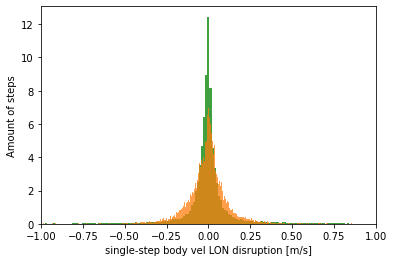

In [131]:
plt.hist(body_vel_disturption_x_array.flatten(), 500, density=True, facecolor='g', alpha=0.75)
plt.hist(body_vel_disturption_x_array_snow.flatten(), 500, density=True, facecolor='C1', alpha=0.75)
plt.xlim(-1,1)
plt.xlabel('single-step body vel LON disruption [m/s]')
plt.ylabel('Amount of steps')

Text(0, 0.5, 'Amount of steps')

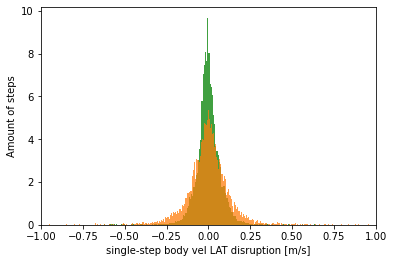

In [132]:
plt.hist(body_vel_disturption_y_array.flatten(), 500, density=True, facecolor='g', alpha=0.75)
plt.hist(body_vel_disturption_y_array_snow.flatten(), 500, density=True, facecolor='C1', alpha=0.75)
plt.xlim(-1,1)
plt.xlabel('single-step body vel LAT disruption [m/s]')
plt.ylabel('Amount of steps')

Text(0, 0.5, 'Amount of steps')

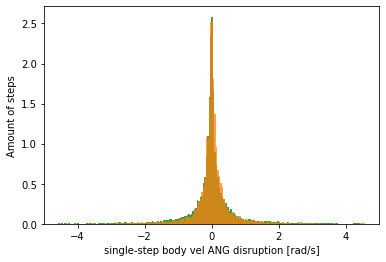

In [133]:
plt.hist(body_vel_disturption_yaw_array.flatten(), 5000, density=True, facecolor='g', alpha=0.75)
plt.hist(body_vel_disturption_yaw_array_snow.flatten(), 5000, density=True, facecolor='C1', alpha=0.75)
plt.xlim(-5,5)
plt.xlabel('single-step body vel ANG disruption [rad/s]')
plt.ylabel('Amount of steps')

In [37]:
# extract various arrays

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'transitory_vel_left_' + str(i)
    str_cmd_right_i = 'transitory_vel_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
cmd_left_vels_array = dataset[cmd_left_str_list].to_numpy()
cmd_right_vels_array = dataset[cmd_right_str_list].to_numpy()

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = dataset[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = dataset[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = dataset[idd_body_vel_yaw_str_list].to_numpy()

icp_body_vel_x_str_list = []
icp_body_vel_y_str_list = []
icp_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    icp_body_vel_x_str_list.append(str_icp_vel_x_i)
    icp_body_vel_y_str_list.append(str_icp_vel_y_i)
    icp_body_vel_yaw_str_list.append(str_icp_vel_yaw_i)
icp_body_vel_x_array = dataset[icp_body_vel_x_str_list].to_numpy()
icp_body_vel_y_array = dataset[icp_body_vel_y_str_list].to_numpy()
icp_body_vel_yaw_array = dataset[icp_body_vel_yaw_str_list].to_numpy()

In [72]:
# compute mean body vel disturbance for each steady-state window
n_windows = len(dataset)


steady_state_mask = dataset['steady_state_mask'].to_numpy() == True

steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

steady_state_icp_body_vel_x = idd_body_vel_x_array[steady_state_mask]
steady_state_icp_body_vel_y = idd_body_vel_y_array[steady_state_mask]
steady_state_icp_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

steady_state_body_vel_disturption_x = body_vel_disturption_x_array[steady_state_mask]
steady_state_body_vel_disturption_y = body_vel_disturption_y_array[steady_state_mask]
steady_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[steady_state_mask]

print(icp_body_vel_x_array.shape)
print(steady_state_idd_body_vel_x.shape)

(633, 40)
(422, 40)


In [73]:
# compute mean body vel disturptions

mean_body_vel_disturption_x = np.mean(steady_state_body_vel_disturption_x, axis=1)
mean_body_vel_disturption_y = np.mean(steady_state_body_vel_disturption_y, axis=1)
mean_body_vel_disturption_yaw = np.mean(steady_state_body_vel_disturption_yaw, axis=1)

print(mean_body_vel_disturption_x.shape)

(422,)


(-2.0, 2.0)

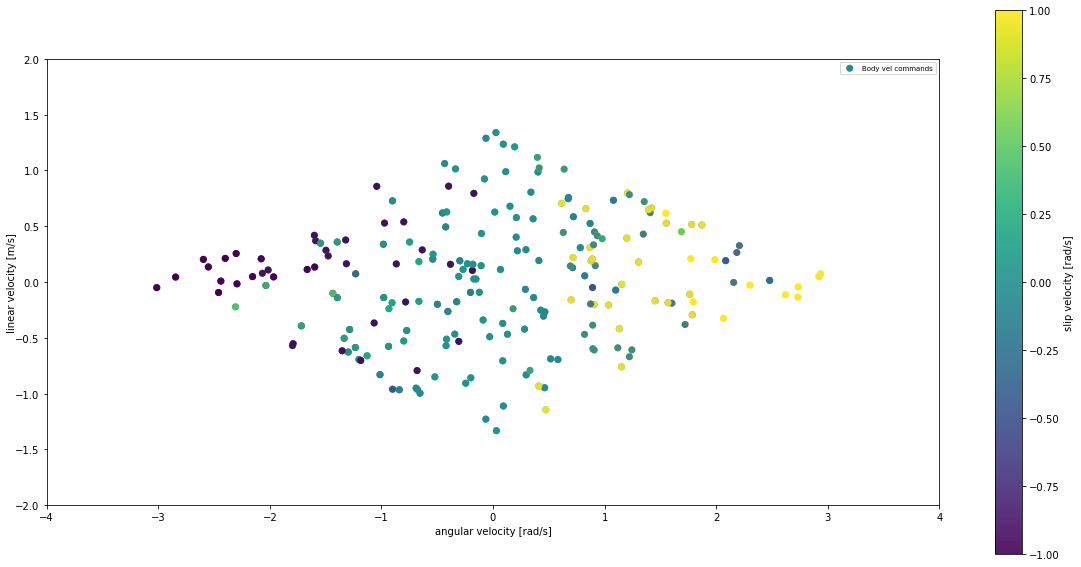

In [84]:
plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

# df_filtered = autorally_df[(autorally_df.linear_v < 25)] #Super weird ultra large values on linar velocity
# print("filtered {} data points".format(len(autorally_df)-len(df_filtered)))

# max_lv = max(np.abs(df_filtered['linear_v']))
# max_av = max(np.abs(df_filtered['angular_v']))


# meas = ax.scatter(df_filtered['angular_v']/(max_av/2.5), df_filtered['linear_v']/(max_lv/2.5), 
#                   c = 'tab:green', 
#                   cmap = 'hot', 
#                   alpha = 0.05, 
#                   lw=0, 
#                   s=5,
#                   label='Autorally encoders-based body velocities',
#                  rasterized=True)

line_width = 5
alpha = 0.2


# q1_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q1_vel_linspace, color='C2', lw=line_width, label='Characterized')
# q2_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q2_vel_linspace, color='C2', lw=line_width)
# q3_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q3_vel_linspace, color='C2', lw=line_width)
# q4_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q4_vel_linspace, color='C2', lw=line_width)

# ax.fill_between(char_angular_vel_linspace_negative, char_q1_vel_linspace, y2=char_q4_vel_linspace, alpha=alpha, color='C2')
# ax.fill_between(char_angular_vel_linspace_positive, char_q2_vel_linspace, y2=char_q3_vel_linspace, alpha=alpha, color='C2')

alpha_plot = 0.9

cmd = ax.scatter(steady_state_idd_body_vel_yaw[:, -1], steady_state_idd_body_vel_x[:, -1], 
                  c = np.clip(mean_body_vel_disturption_yaw, -1, 1), 
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# icp = ax.scatter(icp_body_vel_yaw_array[:, -1], icp_body_vel_x_array[:, -1], 
#                   c = 'C3', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='Body vel measurements',
#                  rasterized=True)

cbar = plt.colorbar(cmd, label='slip velocity [rad/s]')


ax.set_aspect('equal', 'box')

ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(-4, 4)
ax.set_ylim(-2, 2)

(-2.0, 2.0)

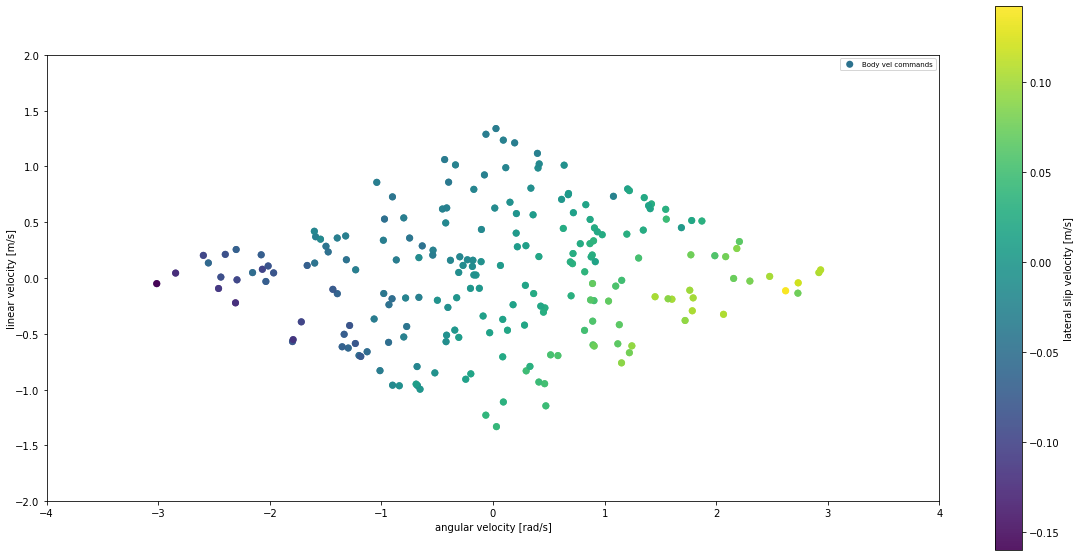

In [85]:
plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

# df_filtered = autorally_df[(autorally_df.linear_v < 25)] #Super weird ultra large values on linar velocity
# print("filtered {} data points".format(len(autorally_df)-len(df_filtered)))

# max_lv = max(np.abs(df_filtered['linear_v']))
# max_av = max(np.abs(df_filtered['angular_v']))


# meas = ax.scatter(df_filtered['angular_v']/(max_av/2.5), df_filtered['linear_v']/(max_lv/2.5), 
#                   c = 'tab:green', 
#                   cmap = 'hot', 
#                   alpha = 0.05, 
#                   lw=0, 
#                   s=5,
#                   label='Autorally encoders-based body velocities',
#                  rasterized=True)

line_width = 5
alpha = 0.2


# q1_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q1_vel_linspace, color='C2', lw=line_width, label='Characterized')
# q2_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q2_vel_linspace, color='C2', lw=line_width)
# q3_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q3_vel_linspace, color='C2', lw=line_width)
# q4_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q4_vel_linspace, color='C2', lw=line_width)

# ax.fill_between(char_angular_vel_linspace_negative, char_q1_vel_linspace, y2=char_q4_vel_linspace, alpha=alpha, color='C2')
# ax.fill_between(char_angular_vel_linspace_positive, char_q2_vel_linspace, y2=char_q3_vel_linspace, alpha=alpha, color='C2')

alpha_plot = 0.9

cmd = ax.scatter(steady_state_idd_body_vel_yaw[:, -1], steady_state_idd_body_vel_x[:, -1], 
                  c = np.clip(mean_body_vel_disturption_y, -0.5, 0.5), 
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# icp = ax.scatter(icp_body_vel_yaw_array[:, -1], icp_body_vel_x_array[:, -1], 
#                   c = 'C3', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='Body vel measurements',
#                  rasterized=True)

cbar = plt.colorbar(cmd, label='lateral slip velocity [m/s]')


ax.set_aspect('equal', 'box')

ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(-4, 4)
ax.set_ylim(-2, 2)

(-2.0, 2.0)

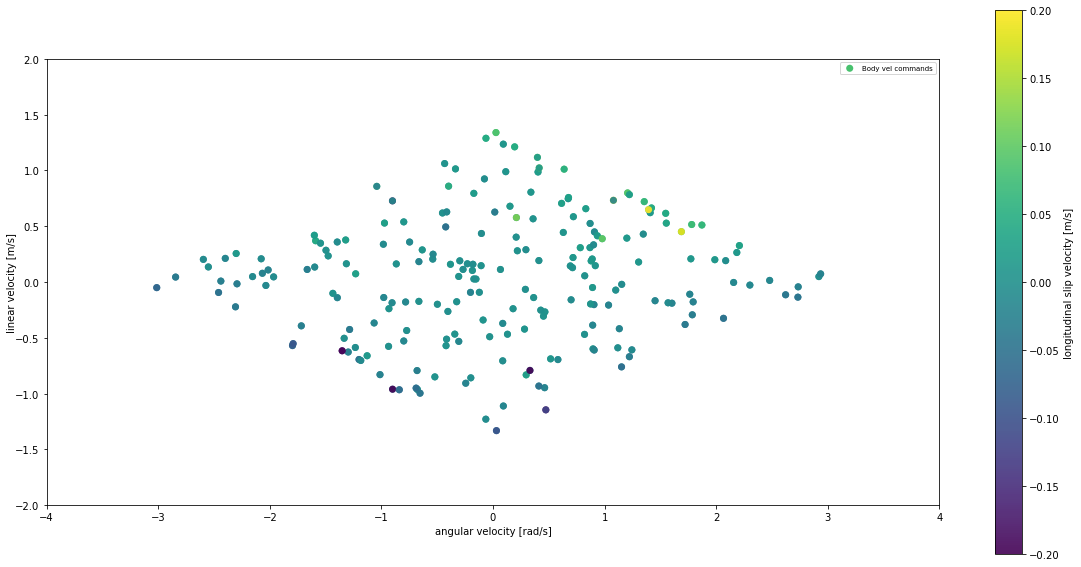

In [145]:
plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

# df_filtered = autorally_df[(autorally_df.linear_v < 25)] #Super weird ultra large values on linar velocity
# print("filtered {} data points".format(len(autorally_df)-len(df_filtered)))

# max_lv = max(np.abs(df_filtered['linear_v']))
# max_av = max(np.abs(df_filtered['angular_v']))


# meas = ax.scatter(df_filtered['angular_v']/(max_av/2.5), df_filtered['linear_v']/(max_lv/2.5), 
#                   c = 'tab:green', 
#                   cmap = 'hot', 
#                   alpha = 0.05, 
#                   lw=0, 
#                   s=5,
#                   label='Autorally encoders-based body velocities',
#                  rasterized=True)

line_width = 5
alpha = 0.2


# q1_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q1_vel_linspace, color='C2', lw=line_width, label='Characterized')
# q2_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q2_vel_linspace, color='C2', lw=line_width)
# q3_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q3_vel_linspace, color='C2', lw=line_width)
# q4_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q4_vel_linspace, color='C2', lw=line_width)

# ax.fill_between(char_angular_vel_linspace_negative, char_q1_vel_linspace, y2=char_q4_vel_linspace, alpha=alpha, color='C2')
# ax.fill_between(char_angular_vel_linspace_positive, char_q2_vel_linspace, y2=char_q3_vel_linspace, alpha=alpha, color='C2')

alpha_plot = 0.9

cmd = ax.scatter(steady_state_idd_body_vel_yaw[:, -1], steady_state_idd_body_vel_x[:, -1], 
                  c = np.clip(mean_body_vel_disturption_x, -0.2, 0.2), 
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# icp = ax.scatter(icp_body_vel_yaw_array[:, -1], icp_body_vel_x_array[:, -1], 
#                   c = 'C3', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='Body vel measurements',
#                  rasterized=True)

cbar = plt.colorbar(cmd, label='longitudinal slip velocity [m/s]')


ax.set_aspect('equal', 'box')

ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(-4, 4)
ax.set_ylim(-2, 2)

In [90]:
# extract transitory windows

transitory_state_mask = dataset['transitory_state_mask'].to_numpy() == True

transitory_state_idd_body_vel_x = idd_body_vel_x_array[transitory_state_mask]
transitory_state_idd_body_vel_y = idd_body_vel_y_array[transitory_state_mask]
transitory_state_idd_body_vel_yaw = idd_body_vel_yaw_array[transitory_state_mask]

transitory_state_icp_body_vel_x = idd_body_vel_x_array[transitory_state_mask]
transitory_state_icp_body_vel_y = idd_body_vel_y_array[transitory_state_mask]
transitory_state_icp_body_vel_yaw = idd_body_vel_yaw_array[transitory_state_mask]

transitory_state_body_vel_disturption_x = body_vel_disturption_x_array[transitory_state_mask]
transitory_state_body_vel_disturption_y = body_vel_disturption_y_array[transitory_state_mask]
transitory_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[transitory_state_mask]

print(icp_body_vel_x_array.shape)
print(transitory_state_idd_body_vel_x.shape)

(633, 40)
(211, 40)


In [99]:
# computed transitory linear and angular acceleration

dt = 0.05

n_transitory_state_windows = transitory_state_idd_body_vel_x.shape[0]
n_timesteps_per_window = transitory_state_idd_body_vel_x.shape[1]

transitory_state_idd_body_acc_x = np.zeros((n_transitory_state_windows, n_timesteps_per_window))
transitory_state_idd_body_acc_yaw = np.zeros((n_transitory_state_windows, n_timesteps_per_window))


for i in range(0, n_transitory_state_windows):
    for j in range(1, n_timesteps_per_window):
        transitory_state_idd_body_acc_x[i,j] = (transitory_state_idd_body_vel_x[i, j] - transitory_state_idd_body_vel_x[i, j-1]) / dt
        transitory_state_idd_body_acc_yaw[i,j] = (transitory_state_idd_body_vel_yaw[i, j] - transitory_state_idd_body_vel_yaw[i, j-1]) / dt
        
print(transitory_state_idd_body_acc_x.shape)
print(transitory_state_body_vel_disturption_x.shape)

(211, 40)
(211, 40)


(-8.0, 8.0)

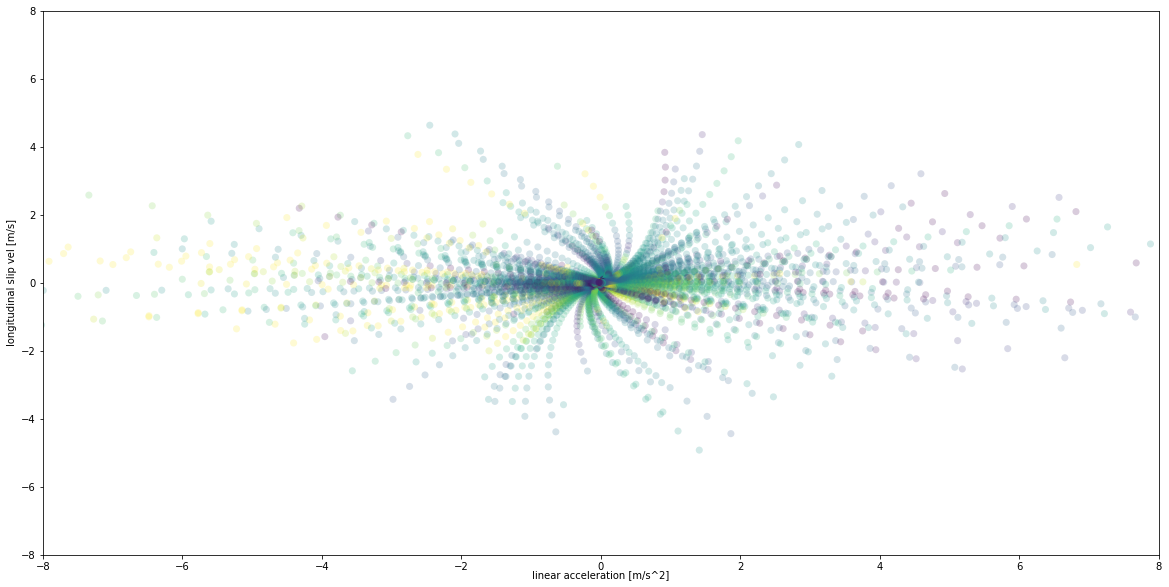

In [144]:
plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

# df_filtered = autorally_df[(autorally_df.linear_v < 25)] #Super weird ultra large values on linar velocity
# print("filtered {} data points".format(len(autorally_df)-len(df_filtered)))

# max_lv = max(np.abs(df_filtered['linear_v']))
# max_av = max(np.abs(df_filtered['angular_v']))


# meas = ax.scatter(df_filtered['angular_v']/(max_av/2.5), df_filtered['linear_v']/(max_lv/2.5), 
#                   c = 'tab:green', 
#                   cmap = 'hot', 
#                   alpha = 0.05, 
#                   lw=0, 
#                   s=5,
#                   label='Autorally encoders-based body velocities',
#                  rasterized=True)

line_width = 5
alpha = 0.2


alpha_plot = 0.2

acc = ax.scatter(transitory_state_idd_body_acc_yaw, transitory_state_idd_body_acc_x, 
                  c = np.clip(transitory_state_body_vel_disturption_y, -0.1, 0.1),
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# acc = ax.scatter(transitory_state_idd_body_acc_yaw, transitory_state_idd_body_acc_x, 
#                   c = np.clip(transitory_state_body_vel_disturption_yaw, -2, 2),
#                   cmap = 'viridis', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='Body vel commands',
#                  rasterized=True)


# ax.set_aspect('equal', 'box')

ax.set_xlabel('linear acceleration [m/s^2]', labelpad=-2)
ax.set_ylabel('longitudinal slip vel [m/s]')

# leg = plt.legend(fontsize=7, loc='best')
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

(-5.0, 5.0)

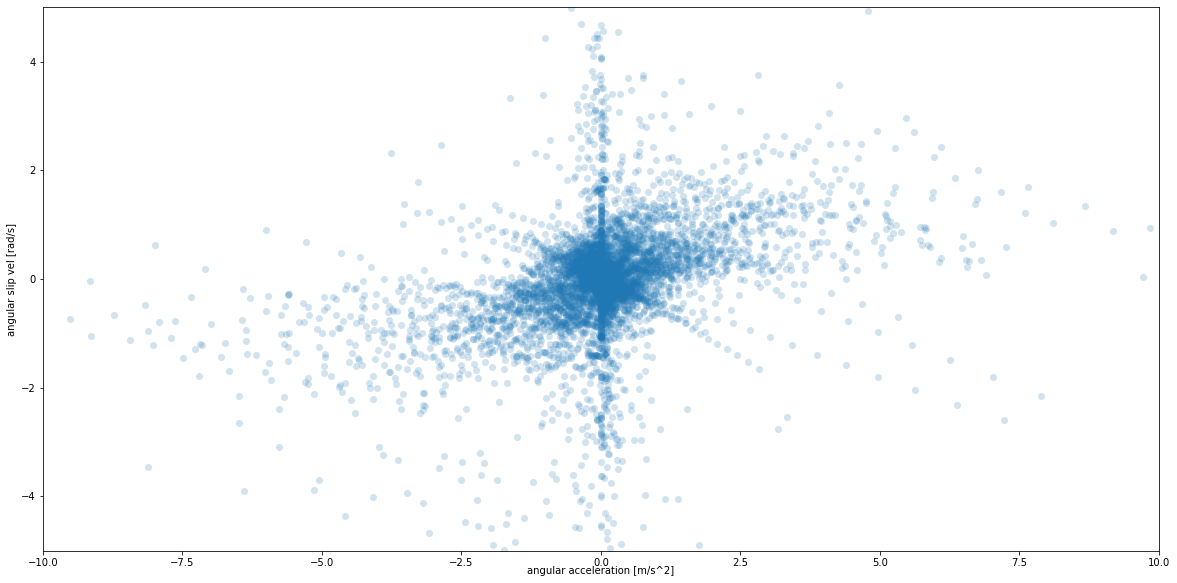

In [116]:
plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

# df_filtered = autorally_df[(autorally_df.linear_v < 25)] #Super weird ultra large values on linar velocity
# print("filtered {} data points".format(len(autorally_df)-len(df_filtered)))

# max_lv = max(np.abs(df_filtered['linear_v']))
# max_av = max(np.abs(df_filtered['angular_v']))


# meas = ax.scatter(df_filtered['angular_v']/(max_av/2.5), df_filtered['linear_v']/(max_lv/2.5), 
#                   c = 'tab:green', 
#                   cmap = 'hot', 
#                   alpha = 0.05, 
#                   lw=0, 
#                   s=5,
#                   label='Autorally encoders-based body velocities',
#                  rasterized=True)

line_width = 5
alpha = 0.2


# q1_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q1_vel_linspace, color='C2', lw=line_width, label='Characterized')
# q2_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q2_vel_linspace, color='C2', lw=line_width)
# q3_char_input_space = ax.plot(char_angular_vel_linspace_positive, char_q3_vel_linspace, color='C2', lw=line_width)
# q4_char_input_space = ax.plot(char_angular_vel_linspace_negative, char_q4_vel_linspace, color='C2', lw=line_width)

# ax.fill_between(char_angular_vel_linspace_negative, char_q1_vel_linspace, y2=char_q4_vel_linspace, alpha=alpha, color='C2')
# ax.fill_between(char_angular_vel_linspace_positive, char_q2_vel_linspace, y2=char_q3_vel_linspace, alpha=alpha, color='C2')

alpha_plot = 0.2

acc = ax.scatter(transitory_state_idd_body_acc_yaw, transitory_state_body_vel_disturption_yaw, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

# icp = ax.scatter(icp_body_vel_yaw_array[:, -1], icp_body_vel_x_array[:, -1], 
#                   c = 'C3', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='Body vel measurements',
#                  rasterized=True)

# cbar = plt.colorbar(cmd, label='longitudinal slip velocity [m/s]')


# ax.set_aspect('equal', 'box')

ax.set_xlabel('angular acceleration [m/s^2]', labelpad=-2)
ax.set_ylabel('angular slip vel [rad/s]')

# leg = plt.legend(fontsize=7, loc='best')
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)

ax.set_xlim(-10, 10)
ax.set_ylim(-5, 5)